# Analysis of data to build a Knowledge Graphs

In the following notebook we analyze each type of data that we need to include in the Knowledge Graphs based on the 10K patients.
The main structure of the graph will be the following:
- Data Group Nodes -> each node has embedded in it the glucose and/or sleep data of a certain patient at time interval dt.
- Patient Nodes -> one node per patient, it has embedded in it the patient's medical history at time interval dt.
- Medical Condition Nodes -> one node per medical condition, the initial embeddings are a one-hot encoded vector.

In [62]:
import pandas as pd
import umap
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shap
import torch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.UltrasoundLoader import UltrasoundLoader
from LabData.DataLoaders.ABILoader import ABILoader
from LabData.DataLoaders.ItamarSleepLoader import ItamarSleepLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataLoaders.MedicalProceduresLoader import MedicalProceduresLoader
from LabData.DataLoaders.Medications10KLoader import Medications10KLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.DemographicsLoader import DemographicsLoader
from LabData.DataLoaders.ECGTextLoader import ECGTextLoader
from LabData.DataLoaders.DEXALoader import DEXALoader
from LabData.DataLoaders.PRSLoader import PRSLoader
from LabData.DataLoaders.HormonalStatusLoader import HormonalStatusLoader
from LabData.DataLoaders.IBSTenkLoader import IBSTenkLoader
from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.FamilyMedicalConditionsLoader import FamilyMedicalConditionsLoader
from LabData.DataLoaders.ChildrenLoader import ChildrenLoader
from LabData.DataLoaders.MentalLoader import MentalLoader
from LabData.DataLoaders.TimelineLoader import TimelineLoader
from LabData.DataLoaders.SubjectRelationsLoader import SubjectRelationsLoader
from LabData.DataLoaders.RetinaScanLoader import RetinaScanLoader
from LabData.DataLoaders.PAStepsLoader import PAStepsLoader

## Sleep Records

ItamarSleepLoader contains the data from the sleep monitroring devices
AHI apnea hapopnea index - https://www.webmd.com/sleep-disorders/sleep-apnea/sleep-apnea-ahi-numbers

In [2]:
sl =ItamarSleepLoader().get_data()
df_sleep = sl.df

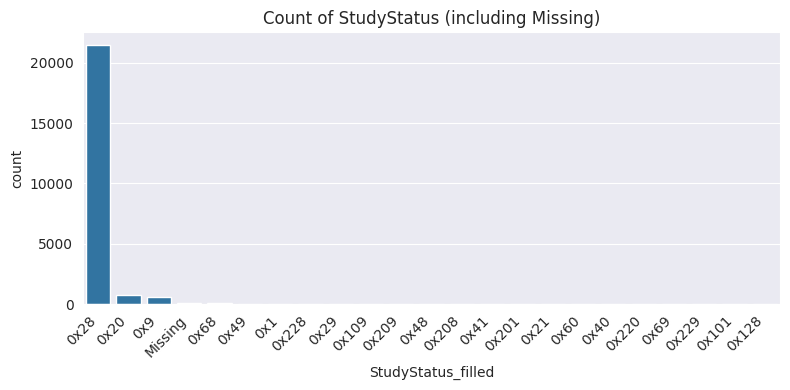

In [3]:
# 1) Fill NaN with "Missing"
df_sleep["StudyStatus_filled"] = df_sleep["StudyStatus"].fillna("Missing")

# 2) Build an ordered list of statuses that actually occur
status_counts = df_sleep["StudyStatus_filled"].value_counts()
valid_statuses = status_counts[status_counts > 0].index  # or .keys()

# 3) Plot, restricting to valid categories and rotating labels
plt.figure(figsize=(8,4))
sns.countplot(data=df_sleep, x="StudyStatus_filled", order=valid_statuses)
plt.xticks(rotation=45, ha="right")
plt.title("Count of StudyStatus (including Missing)")
plt.tight_layout()
plt.show()


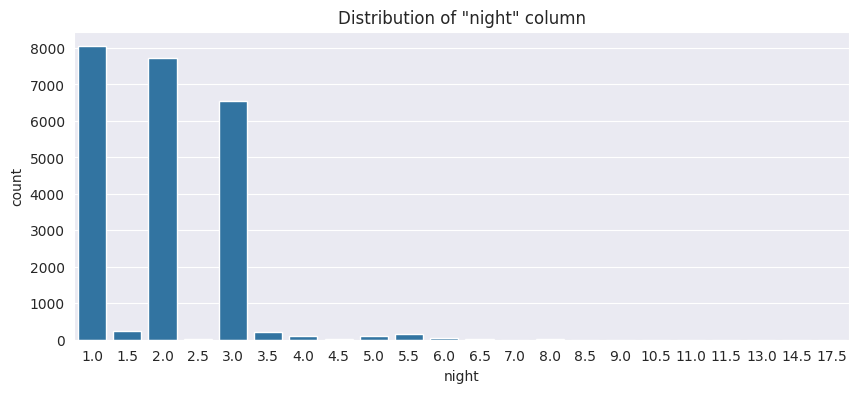

In [4]:
# In [3]:  Distribution of nights
plt.figure(figsize=(10,4))
sns.countplot(data=df_sleep, x='night')
plt.title('Distribution of "night" column')
plt.show()


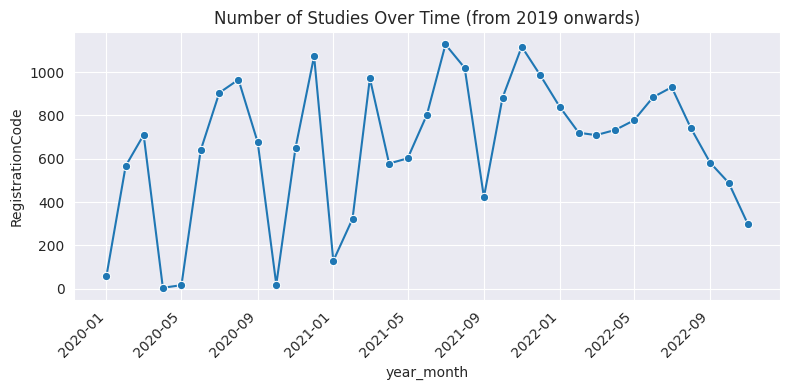

In [5]:
# In [4]: Studies over time (line plot by month)
# First convert Date to datetime, if not already
df_sleep = df_sleep.reset_index()
df_sleep['Date'] = pd.to_datetime(df_sleep['Date'], errors='coerce')

# Convert to period and then to timestamp (representing the first day of the month)
df_sleep['year_month'] = df_sleep['Date'].dt.to_period('M').dt.to_timestamp()

# Filter out dates before 2019
df_sleep = df_sleep[df_sleep['year_month'].dt.year >= 2018]

# Group by the new column and count the number of RegistrationCode entries per month
counts = df_sleep.groupby('year_month')['RegistrationCode'].count().reset_index()

# Plot the lineplot with proper rotation for clarity
plt.figure(figsize=(8, 4))
sns.lineplot(data=counts, x='year_month', y='RegistrationCode', marker='o')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Studies Over Time (from 2019 onwards)')
plt.tight_layout()
plt.show()



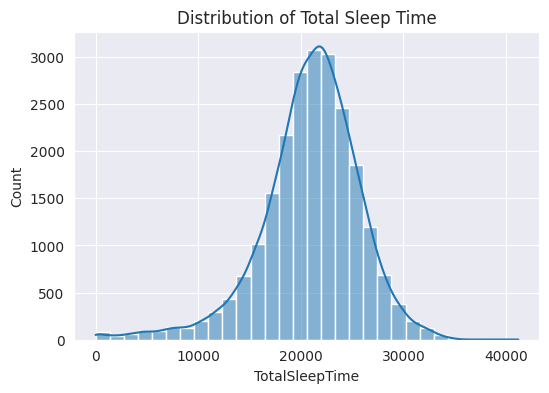

In [6]:
# In [5]:  Histogram of TotalSleepTime
plt.figure(figsize=(6,4))
sns.histplot(data=df_sleep, x='TotalSleepTime', bins=30, kde=True)
plt.title('Distribution of Total Sleep Time')
plt.show()


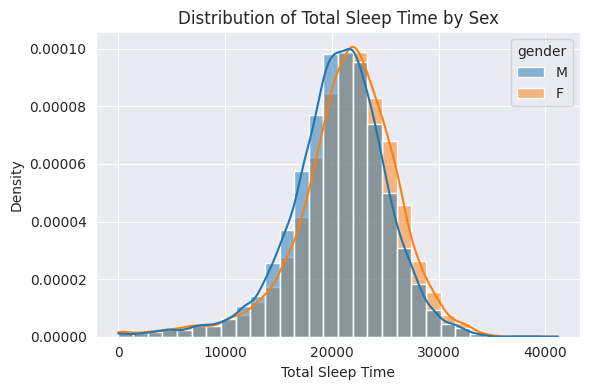

In [7]:
metadata = sl.df_metadata
metadata = metadata.reset_index()
id_gender = metadata[['RegistrationCode', 'Date', 'gender','StudyTypeID']]
# Merge the gender information into df on 'RegistrationCode'
df_sleep = df_sleep.merge(id_gender[['RegistrationCode', 'gender']], on='RegistrationCode', how='left')
# Or after merging
df_sleep['gender'] = df_sleep['gender'].map({1.0: 'M', 0.0: 'F'})

plt.figure(figsize=(6,4))
sns.histplot(
    data=df_sleep,
    x='TotalSleepTime',
    bins=30,
    kde=True,
    hue='gender',       # adjust the column name if needed (e.g. 'Gender')
    stat='density',  # normalize each histogram to density
    common_norm=False  # normalize each group separately
)
plt.title('Distribution of Total Sleep Time by Sex')
plt.xlabel('Total Sleep Time')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


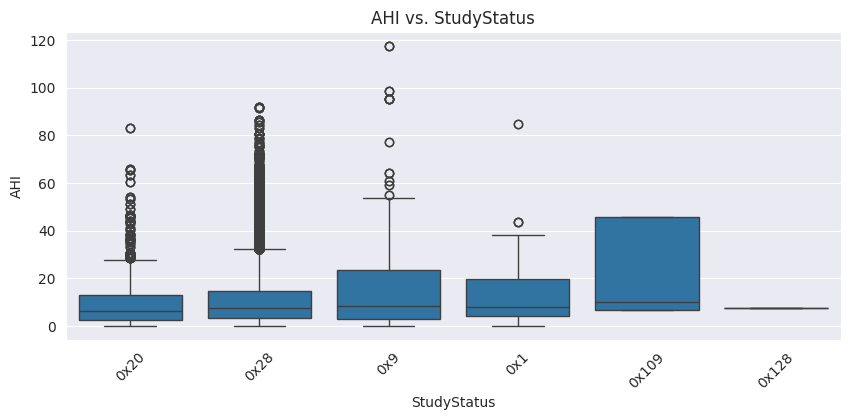

In [8]:
# In [6]:  Boxplot of AHI grouped by StudyStatus
# Filter StudyStatus values that have AHI data points
valid_statuses = df_sleep.groupby('StudyStatus')['AHI'].count()
valid_statuses = valid_statuses[valid_statuses > 0].index

# Plot only the valid statuses
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_sleep[df_sleep['StudyStatus'].isin(valid_statuses)], x='StudyStatus', y='AHI')
plt.title('AHI vs. StudyStatus')
plt.xticks(rotation=45)  # Rotate for readability if needed
plt.show()



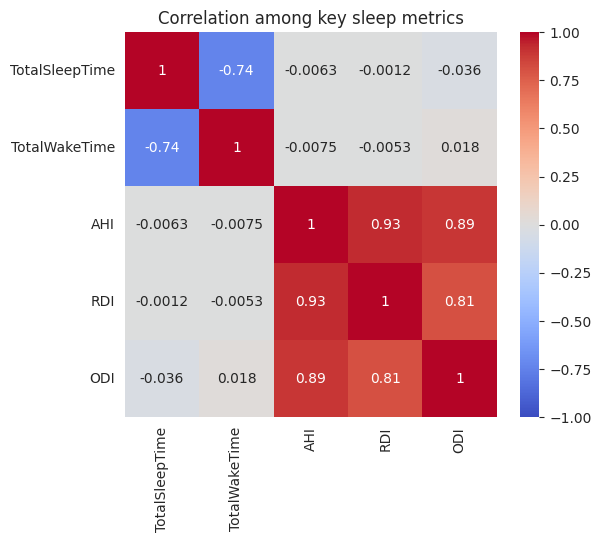

In [9]:
# In [7]:  Correlation heatmap of selected numeric columns
plt.figure(figsize=(6,5))
cols_of_interest = ['TotalSleepTime','TotalWakeTime','AHI','RDI','ODI']
corr = df_sleep[cols_of_interest].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation among key sleep metrics')
plt.show()



In [10]:
df_datapoint_n = df_sleep['RegistrationCode'].value_counts().reset_index()
df_datapoint_n.columns = ['RegistrationCode', 'numbers']

# Sort the dataframe by 'numbers' in descending order
df_datapoint_n = df_datapoint_n.sort_values(by='numbers', ascending=False)

# Print the max and min
max_count = df_datapoint_n['numbers'].max()
min_count = df_datapoint_n['numbers'].min()
unique_ids = df_datapoint_n.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")


Max count: 36
Min count: 1
Unique IDs: 8275


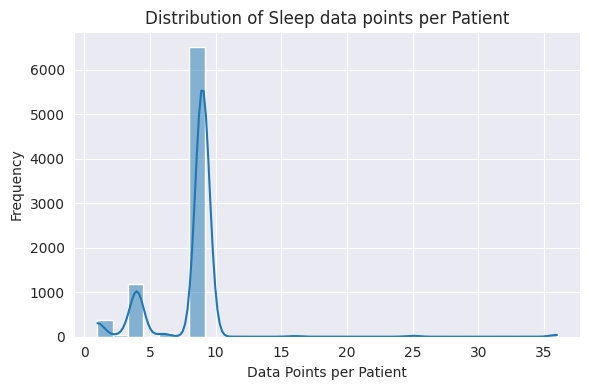

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_datapoint_n, x='numbers', bins=30, kde=True)
plt.title('Distribution of Sleep data points per Patient')
plt.xlabel('Data Points per Patient')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Continuos Glucose Monitor (CGM)

CGM loader contains raw data of cgm sensors that are connected to participants for 2 weeks after the meeting

In [12]:
study_ids = [10, 1001, 1002]
cgm =CGMLoader().get_data(study_ids = study_ids)
df_cgm = cgm.df

In [13]:
df_cgm = df_cgm.reset_index()
df_datapoint_n = df_cgm['RegistrationCode'].value_counts().reset_index()
df_datapoint_n.columns = ['RegistrationCode', 'numbers']

# Sort the dataframe by 'numbers' in descending order
df_datapoint_n = df_datapoint_n.sort_values(by='numbers', ascending=False)

# Print the max and min
max_count = df_datapoint_n['numbers'].max()
min_count = df_datapoint_n['numbers'].min()
unique_ids = df_datapoint_n.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")


Max count: 23086
Min count: 78
Unique IDs: 12904


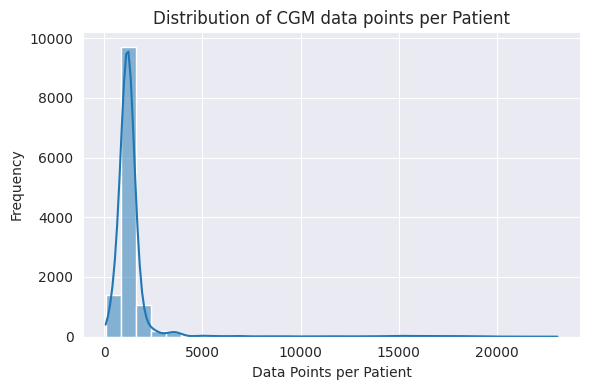

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_datapoint_n, x='numbers', bins=30, kde=True)
plt.title('Distribution of CGM data points per Patient')
plt.xlabel('Data Points per Patient')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

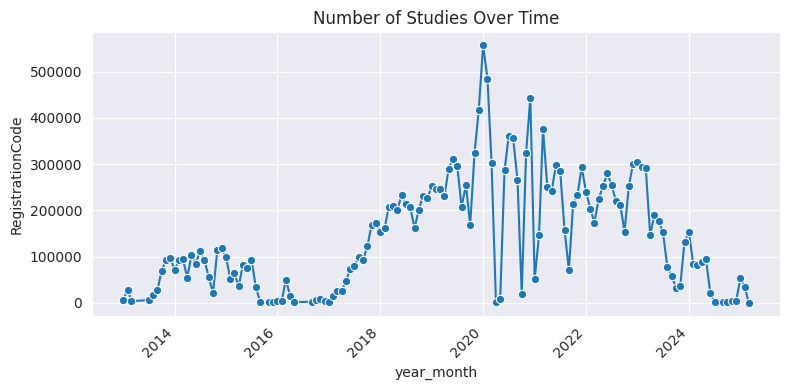

In [15]:
df_cgm = df_cgm.reset_index()
df_cgm['Date'] = pd.to_datetime(df_cgm['Date'], errors='coerce')

# Convert to period and then to timestamp (representing the first day of the month)
df_cgm['year_month'] = df_cgm['Date'].dt.to_period('M').dt.to_timestamp()

# Group by the new column and count the number of RegistrationCode entries per month
counts = df_cgm.groupby('year_month')['RegistrationCode'].count().reset_index()

# Plot the lineplot with proper rotation for clarity
plt.figure(figsize=(8,4))
sns.lineplot(data=counts, x='year_month', y='RegistrationCode', marker='o')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Studies Over Time')
plt.tight_layout()
plt.show()

In [16]:
df_sleep.head(3)

,RegistrationCode,night,Date,StudyStatus,Warnings,BraceletMessage,StudyStartTime,StudyEndTime,TotalApneaSleepTime,TotalAH_CentralValidSleepTime,...,PhysicalSleepTime,PhysicalWakeTime,%DeepSleep,%REM,%LightSleep,%Wake,%Sleep,StudyStatus_filled,year_month,gender
0,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
1,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
2,10K_1000942861,2.0,2021-12-25 22:54:26,0x20,NaN,NaN,82466.0,39266.0,25885.0,NaN,...,2021-12-25 23:03:58.185430463,2021-12-26 08:16:11.298013245,17.777013,29.583763,52.639223,39.437500,60.562500,0x20,2021-12-01,M


In [17]:
df_cgm.head(3)

,index,RegistrationCode,ConnectionID,Date,GlucoseValue,PPGR,year_month
0,0,-1,1,2013-01-21 14:20:50,88.0,0.0,2013-01-01
1,1,-1,1,2013-01-21 14:25:50,89.0,0.0,2013-01-01
2,2,-1,1,2013-01-21 14:30:50,87.0,0.0,2013-01-01


In [18]:

# 1) Ensure dates are datetime
df_sleep['Date'] = pd.to_datetime(df_sleep['Date'], errors='coerce')
df_cgm['Date']   = pd.to_datetime(df_cgm['Date'], errors='coerce')

# 2) Merge on RegistrationCode
merged = pd.merge(
    df_sleep[['RegistrationCode', 'Date']],
    df_cgm[['RegistrationCode', 'Date']],
    on='RegistrationCode',
    how='inner',
    suffixes=('_sleep','_cgm')
)

# 3) Compute absolute difference in days
merged['date_diff_days'] = (
    (merged['Date_sleep'] - merged['Date_cgm']).abs().dt.days
)

# 4) Filter to keep only rows with <= 2 days difference
filtered = merged[merged['date_diff_days'] <= 2]

# 5) Group by RegistrationCode and count how many overlaps
df_sleep_cgm_count = (
    filtered.groupby('RegistrationCode')
            .size()
            .reset_index(name='overlap_count')
)


In [19]:
df_sleep_cgm_count.head()

,RegistrationCode,overlap_count
0,10K_1000942861,1912
1,10K_1002254441,4755
2,10K_1003113258,1604
3,10K_1007330152,5184
4,10K_1008294272,3495


In [20]:
# Print the max and min
max_count = df_sleep_cgm_count['overlap_count'].max()
min_count = df_sleep_cgm_count['overlap_count'].min()
unique_ids = df_sleep_cgm_count.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")

Max count: 16566
Min count: 15
Unique IDs: 5718


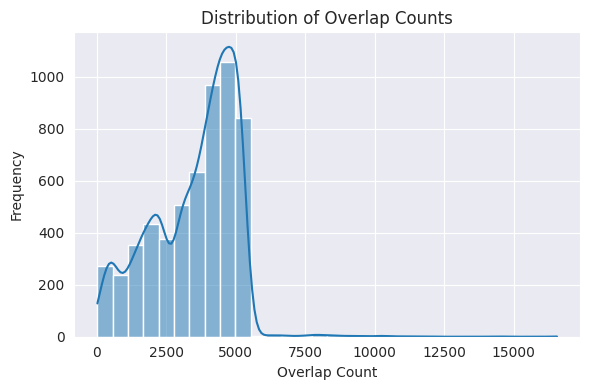

In [21]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_sleep_cgm_count, x='overlap_count', bins=30, kde=True)
plt.title('Distribution of Overlap Counts')
plt.xlabel('Overlap Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

We need to create the embeddings from the medical data of each patient, and from the sleep and glucose data. Let's start from the medical data

In [22]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    # Use the CLS token representation as the embedding:
    embedding = outputs.last_hidden_state[:, 0, :]
    return embedding
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
sample_text = "Patient exhibits signs of mild sleep apnea and elevated blood glucose."
sample_text_1 = "The patients cannot sleep well, eats a lot of sugary food, and has reported heavy snoring"
sample_text_2 = "The patient is all good"
embedding = get_embedding(sample_text)
embedding_1 = get_embedding(sample_text_1)
embedding_2 = get_embedding(sample_text_2)
print(embedding.shape)
print(embedding_1.shape)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([1, 768])
torch.Size([1, 768])


## Medical Condition Analysis

MedicalConditionLoader contains medical conditions reported throught the surveys and to the coordinators in the clinic
the date is approximation of the start of the condition, the main data is ICD11 code (df_columns_metadata contains translation of this ICD11 code)

In [24]:
medical_condition = MedicalConditionLoader().get_data().df
medical_condition_columns_metadata = MedicalConditionLoader().get_data().df_columns_metadata
medical_condition.head(3)


AttributeError: 'DataFrame' object has no attribute 'append'

In [128]:
fam_medical_condition = FamilyMedicalConditionsLoader().get_data().df
fam_medical_condition_columns_metadata = FamilyMedicalConditionsLoader().get_data().df_columns_metadata
fam_medical_condition.head(3)

/tmp/ipykernel_230869/2967645717.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return original_to_datetime(arg, format=format, **kwargs)


AttributeError: 'Index' object has no attribute 'year'

get_data arguments:
relevant study_ids = [10, 1001, 1002] ----1001 - beilinson ---1002 - cancer relevant research stages = ['baseline','00_01_visit', '00_02_visit','01_00_call','01_01_visit','02_00_visit', '02_01_visit','02_02_visit','03_00_call','03_00_visit','03_01_visit']

In [24]:
study_ids = [10, 1001, 1002]
SubjectLoader().get_data(study_ids=study_ids).df.head(3)

,,StudyTypeID,city,country,gender,month_of_birth,us_state,yob,StudyTypeID2,StudyTypeID3,StudyTypeID4,StudyTypeID5,StudyTypeID6,StudyTypeID7,StudyTypeID8,StudyTypeID9,age,tz
RegistrationCode,Date,,,,,,,,,,,,,,,,,
10K_1000028368,2020-03-22 08:26:05.077073,10.0,None,IL,1.0,9,None,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,Asia/Jerusalem
10K_1000273395,2020-03-05 20:53:54.399388,10.0,None,IL,1.0,3,None,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Asia/Jerusalem
10K_1000633050,2021-06-21 14:23:50.372010,10.0,None,IL,0.0,7,None,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,Asia/Jerusalem


In [25]:
bm = BodyMeasuresLoader().get_data(study_ids=study_ids).df.join(BodyMeasuresLoader().get_data(study_ids=study_ids).df_metadata)

general_info = bm.reset_index().set_index('RegistrationCode')
general_info = general_info[~general_info['gender'].isna()]
general_info = general_info[~general_info['age'].isna()]

gender_dictionary = {1:'male', 0:'female'}

general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)

general_info.head(10)

/tmp/ipykernel_46668/1518352966.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['male' 'female' 'female' ... 'male' 'male' 'female']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)


,Date,standing_three_min_blood_pressure_diastolic,dizziness,trunk_fat,lying_blood_pressure_pulse_rate,body_fat,is_getting_period,fingers_grip_left,lying_blood_pressure_systolic,hand_grip_left,...,blood_pressure_letter_to_physician,age,sitting_another_hand_blood_pressure_pulse_rate,us_state,country,month_of_birth,StudyTypeID5,StudyTypeID2,StudyTypeID8,sitting_second_blood_pressure_diastolic
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:09:38.954985,90.0,False,NaN,50.0,NaN,NaN,NaN,139.0,134.199997,...,NaN,54.0,NaN,None,IL,8.0,NaN,NaN,NaN,NaN
10K_1001201093,2021-08-26 07:39:21.411519,74.0,False,NaN,66.0,NaN,NaN,NaN,100.0,69.699997,...,NaN,42.0,NaN,None,IL,8.0,NaN,NaN,NaN,NaN
10K_1001201093,2023-09-12 10:23:05.534125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,...,Not Given,44.0,73.0,None,IL,8.0,NaN,NaN,NaN,57.0
10K_1002033709,2022-08-03 07:20:01.044769,78.0,True,NaN,60.0,NaN,NaN,NaN,106.0,59.000000,...,Not Given,43.0,NaN,None,IL,10.0,NaN,NaN,NaN,74.0
10K_1002087123,2019-12-04 11:53:40.350115,92.0,False,42.799999,72.0,45.099998,Yes,NaN,128.0,59.700001,...,NaN,42.0,NaN,None,IL,11.0,NaN,NaN,NaN,NaN
10K_1002087123,2022-03-22 11:42:27.565348,93.0,False,NaN,79.0,NaN,NaN,NaN,127.0,63.400002,...,NaN,45.0,NaN,None,IL,11.0,NaN,NaN,NaN,NaN
10K_1002254441,2022-09-15 07:00:31.408388,80.0,False,NaN,66.0,NaN,NaN,NaN,105.0,86.400002,...,Not Given,45.0,NaN,None,IL,11.0,NaN,NaN,NaN,72.0
10K_1002254441,2025-02-13 06:20:52.699166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.599998,...,Not Given,48.0,60.0,None,IL,11.0,NaN,NaN,NaN,74.0
10K_1003113258,2020-02-09 12:38:07.180299,83.0,False,27.799999,50.0,36.599998,NaN,NaN,138.0,98.900002,...,NaN,49.0,NaN,None,IL,1.0,NaN,NaN,NaN,NaN


In [26]:
general_info.shape

(21188, 65)

In [27]:
general_info = general_info.reset_index()

In [28]:
# Count the number of unique RegistrationCodes
unique_count = general_info['RegistrationCode'].nunique()

# Calculate the frequency for each unique RegistrationCode
frequency_series = general_info['RegistrationCode'].value_counts()

# Compute the average and median frequencies
average_frequency = frequency_series.mean()
median_frequency = frequency_series.median()

print("Unique RegistrationCodes:", unique_count)
print("Average frequency per RegistrationCode:", average_frequency)
print("Median frequency per RegistrationCode:", median_frequency)


Unique RegistrationCodes: 12222
Average frequency per RegistrationCode: 1.7335951562755687
Median frequency per RegistrationCode: 2.0


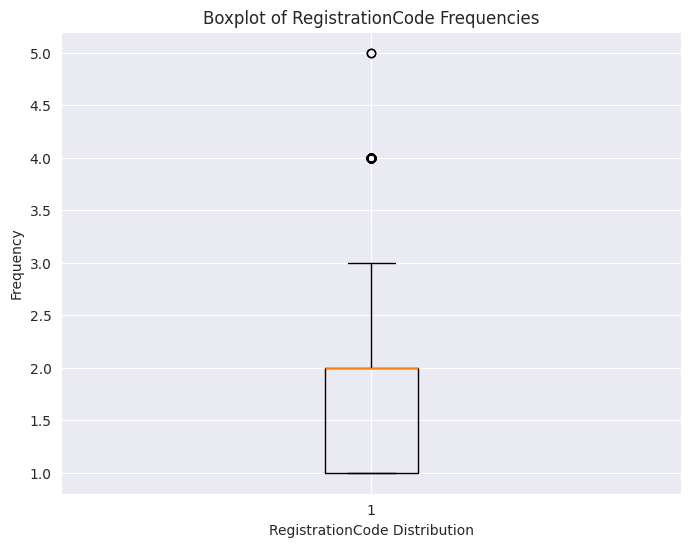

In [30]:
plt.figure(figsize=(8, 6))
plt.boxplot(frequency_series, vert=True)
plt.xlabel('RegistrationCode Distribution')
plt.ylabel('Frequency')
plt.title('Boxplot of RegistrationCode Frequencies')
plt.show()



In [31]:
# Count how many RegistrationCodes have frequencies of 1 through 5
frequency_counts = frequency_series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
for freq, count in frequency_counts.items():
    print(f"Number of RegistrationCodes with frequency {freq}: {count}")

Number of RegistrationCodes with frequency 1: 5353
Number of RegistrationCodes with frequency 2: 4850
Number of RegistrationCodes with frequency 3: 1943
Number of RegistrationCodes with frequency 4: 74
Number of RegistrationCodes with frequency 5: 2


In [29]:
path_file = '/net/mraid20/export/genie/LabData/Data/10K/for_review/'
file_name = 'follow_up_conditions_all.csv'
file_name_1 = 'baseline_conditions_all.csv'
full_path = path_file + file_name
full_path_1 = path_file + file_name_1

# Read the CSV file into a DataFrame
df_conditions_follow_up = pd.read_csv(full_path)
df_conditions_baseline = pd.read_csv(full_path_1)

# Display the first few rows of the DataFrame
df_conditions_follow_up.head()

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
0,10K_1001201093,RA01,560,2022-05-01 00:00:00.000000,True,קורונה,2022-08-02 05:48:59.526988+00:00,01_00_call,Infectious Disease,COVID-19,COVID-19,2021-08-26 07:39:21.411519
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115
4,10K_1007330152,RA01,564,2023-01-01 00:00:00.000000,True,קורונה,2023-11-12 06:33:59.308045+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2020-11-16 12:25:48.195845


In [33]:
df_conditions_baseline.head()

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
0,10K_1000942861,BlockL2-6A7,2008-01-01,True,דיכאון,2021-06-11 11:51:55,baseline,Neurologic,Depression,Depressive disorders,NaN,NaN
1,10K_1000942861,DB60,2000-01-01,True,טחורים,2021-06-11 11:51:55,baseline,Surgery,Haemorrhoids,Haemorrhoids,NaN,NaN
2,10K_1000942861,RA01,2020-12-23,True,קורונה,2023-12-25 12:52:12.534390+00:00,baseline,Infectious Disease,COVID-19,COVID-19,NaN,NaN
3,10K_1002033709,ED80,2000-01-01,True,אקנה,2022-01-11 07:16:11.594000,baseline,Dermatology,Allergy,Acne,NaN,NaN
4,10K_1002033709,GC08.Z,2000-01-01,True,דלקת בשתן,2022-01-11 07:16:11.594000,baseline,Urology,Urinary tract infection,"Urinary tract infection, site and agent not sp...",NaN,NaN


In [60]:
df_conditions_baseline['english_name'].value_counts()

english_name
Hyperlipoproteinaemia                       2535
Haemorrhoids                                2432
Spinal pain                                 2331
Attention deficit hyperactivity disorder    2196
Allergic rhinitis                           1391
                                            ... 
Acute pericarditis                             1
Fracture of shoulder or upper arm              1
Non-alcoholic steatohepatitis                  1
Horner syndrome                                1
Tourette syndrome                              1
Name: count, Length: 427, dtype: int64

In [35]:
df_conditions_follow_up['english_name'].value_counts()

english_name
COVID-19                                                                                   6157
Hyperlipoproteinaemia                                                                       382
Essential hypertension                                                                      219
Intermediate hyperglycaemia                                                                 196
Other specified conditions associated with the spine (intervertebral disc displacement)      91
                                                                                           ... 
Perforation of tympanic membrane                                                              1
Essential tremor or related tremors                                                           1
Spondylolisthesis                                                                             1
Pericardial effusion                                                                          1
Allergic rhinitis          

In [36]:
df_conditions_baseline['research_stage'].value_counts()

research_stage
baseline       38725
01_00_call        15
02_00_visit        6
Name: count, dtype: int64

In [37]:
df_conditions_follow_up['research_stage'].value_counts()

research_stage
01_00_call     3901
02_00_visit    2233
03_00_call     2109
04_00_visit     384
05_00_call      203
04_01_call       48
02_01_call       42
01_01_visit       5
06_00_visit       3
01_01_call        2
00_01_visit       1
03_01_visit       1
Name: count, dtype: int64

In [38]:
common_codes = pd.merge(df_conditions_baseline[['RegistrationCode']],
                           df_conditions_follow_up[['RegistrationCode']],
                           on='RegistrationCode',
                           how='inner')['RegistrationCode'].unique().tolist()

len(common_codes)

5983

In [39]:
df_conditions_baseline[df_conditions_baseline['RegistrationCode'] == common_codes[0]]

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
5,10K_1002087123,6A05,2000-01-01,True,הפרעות קשב וריכוז,2019-10-25 12:55:22,baseline,Neurologic,Attention Deficit Disorder (ADHD),Attention deficit hyperactivity disorder,NaN,NaN
6,10K_1002087123,BA00,2000-01-01,True,יתר לחץ דם,2019-10-25 12:55:22,baseline,Cardiovascular,Hypertension,Essential hypertension,NaN,NaN


In [40]:
df_conditions_follow_up[df_conditions_follow_up['RegistrationCode'] == common_codes[0]]

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115


In [41]:
# Merge DataFrames on 'RegistrationCode' and 'english_name' to find common records
common_conditions = pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')['RegistrationCode'].nunique()


# Display the result
print(f"Number of patients with the same disease in both DataFrames: {common_conditions}")

Number of patients with the same disease in both DataFrames: 5


In [42]:
pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')

,RegistrationCode,medical_condition_x,Date_x,Start_x,name_x,created_at_x,research_stage_x,Group_x,Consolidated name_x,english_name,...,medical_condition_y,index_y,Date_y,Start_y,name_y,created_at_y,research_stage_y,Group_y,Consolidated name_y,Baseline_Date_y
0,10K_2842497388,BlockL2-6A7,2023-01-01,True,דיכאון,2023-12-19 04:02:52.950523+00:00,baseline,Neurologic,Depression,Depressive disorders,...,6A7,2935,2024-01-01 00:00:00.000000,True,דיכאון (6A7),2024-11-25 16:40:54.433800+00:00,01_00_call,Neurologic,Depression,2023-12-18 07:07:55.605764
1,10K_5904281650,BlockL2-FA0,2000-01-01,True,אוסטאוארטריטיס,2020-02-06 14:21:20,baseline,Rheumatology,Osteoarthritis,Osteoarthritis,...,FA0,7020,2021-01-01 00:00:00.000000,True,אוסטאוארטריטיס (FA0),2023-07-09 07:54:47.912081+00:00,01_00_call,Rheumatology,Osteoarthritis,2020-06-23 10:14:23.788501
2,10K_6205511815,BlockL1-3A0,2000-01-01,True,אנמיה,2021-03-19 14:34:10,baseline,Hematological,Anemia,Anaemias or other erythrocyte disorders,...,3A0,7417,2023-01-01 00:00:00.000000,True,אנמיה (3A0),2023-06-20 11:08:48.345285+00:00,02_00_visit,Hematological,Anemia,2021-05-26 07:38:06.029521
3,10K_9249892338,BlockL2-6A7,2010-01-01 00:00:00.000000,True,דיכאון,2020-08-19 12:58:02,baseline,Neurologic,Depression,Depressive disorders,...,6A7,11375,2024-07-01 00:00:00.000000,True,דיכאון (6A7),2024-11-14 08:05:27.592965+00:00,04_00_visit,Neurologic,Depression,2020-08-25 10:27:33.462690
4,10K_9626336152,BA80,2000-01-01 00:00:00.000000,True,מחלת עורקים כלילית (BA80),2024-12-23 15:27:13.627000+00:00,baseline,Cardiovascular,Atherosclerotic disease,Coronary atherosclerosis,...,BA52,11888,2024-09-01 00:00:00.000000,True,טרשת עורקים בעורקי הלב הכליליים (קורונארים),2024-12-23 15:27:13.627000+00:00,03_00_call,Cardiovascular,Ischemic Heart Disease,2022-01-06 11:08:17.819071


In [56]:
# ----- Step 1: Prepare the Data -----

# Assume you have two DataFrames:
# df_condition_baseline: Contains patient conditions with columns "RegistrationCode" and "english_name"
# general_info: Contains additional clinical information for patients with a "RegistrationCode" column

# Example (dummy) DataFrames:
# df_condition_baseline = pd.read_csv("df_condition_baseline.csv")
# general_info = pd.read_csv("general_info.csv")

# For demonstration, let's assume these DataFrames are already defined.
# Get the unique patient IDs from df_condition_baseline:
unique_patients = df_conditions_baseline["RegistrationCode"].unique()

# ----- Step 2: Load Clinical BERT Model -----

# Load Clinical BERT (Bio_ClinicalBERT) tokenizer and model from Hugging Face:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Set model to evaluation mode (no gradients needed)
model.eval()

# ----- Step 3: Create a Node for Each Patient with an Embedding -----

patient_embeddings = {}

for patient in unique_patients:
    # Get all condition names for the patient from df_condition_baseline.
    conditions = df_conditions_baseline.loc[
        df_conditions_baseline["RegistrationCode"] == patient, "english_name"
    ]
    # Combine the condition names into a single string (unique conditions separated by a semicolon)
    combined_conditions = "; ".join(conditions.astype(str).unique())

    # Get the patient's clinical information from general_info.
    # Here we assume that general_info contains a row per patient and that all columns (except RegistrationCode)
    # contain clinical info. Adjust this part based on your actual data.
    patient_info_rows = general_info.loc[general_info["RegistrationCode"] == patient]
    if not patient_info_rows.empty:
    # Get the first (and assuming only) row for this patient, excluding "RegistrationCode".
        row = patient_info_rows.drop(columns=["RegistrationCode"]).iloc[0]

    # Build a list of "column_name: value" strings, ignoring NaN values.
        info_parts = []
        for col, val in row.items():
            if pd.notna(val):
                info_parts.append(f"{col}: {val}")

    # Join the parts into a single string
        patient_info_text = " ".join(info_parts)
    else:
        patient_info_text = ""

    # Combine conditions and clinical information into one text.
    text_prompt = f"Conditions: {combined_conditions}. Medical Info: {patient_info_text}"

    # ----- Step 4: Generate the Embedding Using Clinical BERT -----

    # Tokenize the text; truncate to max 512 tokens if needed.
    inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)

    # Generate embeddings with no gradient calculations.
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding (first token) as the representation.
    # outputs.last_hidden_state shape: (batch_size, sequence_length, hidden_size)
    embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)

    # Save the embedding (squeeze to remove batch dimension).
    patient_embeddings[patient] = embedding.squeeze(0)

# ----- Optional: Create a Tensor of All Node Embeddings -----
# Each row corresponds to a patient in the order of unique_patients.
all_embeddings = torch.stack([patient_embeddings[pid] for pid in unique_patients], dim=0)

print("Generated embeddings for each patient node:")
print(all_embeddings.shape)  # e.g., (num_patients, hidden_size)


Generated embeddings for each patient node:
torch.Size([11408, 768])


In [57]:
all_embeddings[0]

tensor([-1.7964e-01,  1.1022e-01, -3.4997e-01,  4.4496e-01, -1.3656e-01,
         9.1815e-02,  8.3227e-01,  1.3211e-01,  2.5013e-02,  2.2073e-01,
        -6.2710e-01,  3.6856e-01,  1.5948e-01,  6.6771e-02, -5.7225e-01,
        -1.5390e-01,  3.0423e-01,  3.5372e-01,  1.0091e-01, -4.6056e-01,
        -4.3296e-02,  1.3811e-01,  2.6073e-01, -2.5143e-01, -1.8613e-01,
        -3.5733e-01,  6.2798e-01,  6.4744e-01,  1.1449e-01,  3.4617e-01,
         2.1774e-01,  3.7842e-01, -2.7336e-01, -2.9510e-01, -9.0766e-02,
         5.6411e-02,  2.6986e-01, -5.3130e-01, -6.6968e-02,  5.8214e-01,
        -5.8716e-01, -2.0163e-01,  5.1165e-01,  3.0645e-01,  6.0661e-01,
         3.8376e-02, -6.2562e-02,  2.1790e-01, -6.0652e-01,  7.4399e-01,
        -4.8068e-02,  1.3348e-01,  3.1381e-01,  3.4057e-01,  1.8854e-01,
        -2.0346e-01,  3.7248e-01, -1.2901e-01, -3.6902e-01,  3.3239e-01,
        -2.3594e-01,  2.0423e-01, -2.7928e-03, -3.1856e-01, -8.9901e-01,
         1.3635e-01, -2.5753e-01,  3.4352e-01, -2.1

In [59]:
# ----- Step 4: Save the Embeddings for Easy Retrieval -----
# Option A: Save as a PyTorch file
torch.save({'RegistrationCodes': unique_patients, 'embeddings': all_embeddings}, 'patient_embeddings.pt')

# Option B: Convert to a DataFrame and save as CSV
embedding_dim = all_embeddings.shape[1]
embeddings_list = [patient_embeddings[pid].tolist() for pid in unique_patients]

embedding_df = pd.DataFrame(embeddings_list, columns=[f'emb_{i}' for i in range(embedding_dim)])
embedding_df.insert(0, 'RegistrationCode', unique_patients)
embedding_df.to_csv("patient_embeddings.csv", index=False)

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [61]:
excluded_conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate",
    "Basal cell carcinoma of skin"
]

# ----- Helper: Stage Parsing for Ordering & Comparison -----
def stage_to_tuple(stage):
    """
    Convert a research stage string (e.g., "01_00_call", "01_01_visit") to a tuple
    for ordering and comparison.
    """
    parts = stage.split('_')
    # parts[0] = years (nn), parts[1] = event number (xx), parts[2] = type ("call"/"visit")
    return (int(parts[0]), int(parts[1]), parts[2])

# ----- Assume DataFrames Are Loaded -----
# df_conditions_follow_up: contains at least the columns "RegistrationCode", "english_name", and "research_stage".
# general_info: contains personal/clinical information for patients, with a "RegistrationCode" column.
# For example:
# df_conditions_follow_up = pd.read_csv("df_conditions_follow_up.csv")
# general_info = pd.read_csv("general_info.csv")

# ----- Stage Ordering -----
unique_stages = sorted(df_conditions_follow_up["research_stage"].unique(), key=lambda s: stage_to_tuple(s))

# ----- Determine Each Patient's Earliest Diagnosis Stage -----
# A patient is considered diagnosed at the earliest stage where they have a condition not in the excluded list.
diagnosis_df = df_conditions_follow_up[~df_conditions_follow_up["english_name"].isin(excluded_conditions)]
earliest_diagnosis = {}
for patient, group in diagnosis_df.groupby("RegistrationCode"):
    # Pick the minimum stage according to our ordering
    stages = group["research_stage"].unique()
    earliest_stage = min(stages, key=lambda s: stage_to_tuple(s))
    earliest_diagnosis[patient] = earliest_stage

# ----- Load Clinical BERT -----
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model.eval()  # Set to evaluation mode

# ----- Process Follow-Up Stages & Generate Patient Embeddings -----
embedding_rows = []  # List to collect embedding records (dictionaries)

for stage in unique_stages:
    # Select rows for the current stage
    stage_df = df_conditions_follow_up[df_conditions_follow_up["research_stage"] == stage]
    # Get unique patients in this stage
    patients_in_stage = stage_df["RegistrationCode"].unique()

    for patient in patients_in_stage:
        # Decide whether to include the patient in this stage.
        # If the patient has an earliest diagnosis stage, only include if current stage <= diagnosis stage.
        if patient in earliest_diagnosis:
            if stage_to_tuple(stage) > stage_to_tuple(earliest_diagnosis[patient]):
                # Patient was diagnosed in an earlier stage; skip them in later stages.
                continue

        # Combine all follow-up conditions (english_name) for the patient in this stage
        patient_stage_conditions = stage_df.loc[stage_df["RegistrationCode"] == patient, "english_name"]
        combined_conditions = "; ".join(patient_stage_conditions.astype(str).unique())

        # Retrieve the patient's additional info from general_info (if available)
        patient_info_rows = general_info.loc[general_info["RegistrationCode"] == patient]
        if not patient_info_rows.empty:
            # Use the first row (assuming one row per patient) and drop "RegistrationCode"
            row = patient_info_rows.drop(columns=["RegistrationCode"]).iloc[0]
            # Build a list of "column_name: value" strings, skipping columns with NaN values
            info_parts = []
            for col, val in row.items():
                if pd.notna(val):
                    info_parts.append(f"{col}: {val}")
            patient_info_text = " ".join(info_parts)
        else:
            patient_info_text = ""

        # Create a text prompt combining the follow-up conditions and detailed patient info with column names
        text_prompt = f"Follow-up Conditions: {combined_conditions}. Medical Info: {patient_info_text}"

        # Tokenize and generate the embedding using Clinical BERT
        inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token's embedding as the representation
        embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)

        # Prepare a record to later build a DataFrame
        embedding_dict = {
            "RegistrationCode": patient,
            "research_stage": stage
        }
        # Convert the embedding tensor to a list and add each dimension as a separate column
        embedding_list = embedding.tolist()
        for i, val in enumerate(embedding_list):
            embedding_dict[f"emb_{i}"] = val

        embedding_rows.append(embedding_dict)

# ----- Save the Embeddings to CSV -----
embedding_df = pd.DataFrame(embedding_rows)
embedding_df.to_csv("followup_patient_embeddings.csv", index=False)
print("Saved follow-up patient embeddings to followup_patient_embeddings.csv")

Saved follow-up patient embeddings to followup_patient_embeddings.csv


In [50]:
embedding_df.shape

(6994, 770)

In [51]:
all_embeddings.shape

torch.Size([11408, 768])

In [55]:
merged_df = pd.merge(df_cgm,
                     df_conditions_baseline[["RegistrationCode", "Date"]],
                     on="RegistrationCode",
                     how="inner")
filtered_df = merged_df[
    (merged_df["Date_x"] >= merged_df["Date_y"]) &
    (merged_df["Date_x"] <= merged_df["Date_y"] + pd.Timedelta(days=2))
]

# Count the number of unique patients with a glucose measurement within 2 days of baseline
num_patients = filtered_df["RegistrationCode"].nunique()
print("Number of patients with a glucose measurement within 2 days of baseline:", num_patients)

TypeError: unsupported operand type(s) for +: 'Timedelta' and 'str'

In [41]:
study_ids

[10, 1001, 1002]

In [63]:
# get general medical info fo reach patient
study_ids = [10, 1001, 1002]
bm = BodyMeasuresLoader().get_data(study_ids=study_ids).df.join(BodyMeasuresLoader().get_data(study_ids=study_ids).df_metadata)
general_info = bm.reset_index()
general_info = general_info[~general_info['gender'].isna()]
general_info = general_info[~general_info['age'].isna()]

# get the patient embeddings obtained with ClinicalBERT
embeddings_df_baseline = pd.read_csv("patient_embeddings.csv")
# get the baseline conditions of each patient, to then use them to test clustering power
path_file = '/net/mraid20/export/genie/LabData/Data/10K/for_review/'
file_name = 'baseline_conditions_all.csv'
file_name_1 = 'follow_up_conditions_all.csv'
full_path = path_file + file_name

# Read the CSV file into a DataFrame
df_conditions_baseline = pd.read_csv(full_path)
df_conditions_follow_up = pd.read_csv(path_file + file_name_1)

In [113]:

conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate"
]

# Step 1: Identify patients with the 6 specific conditions in df_conditions_baseline
patients_with_specific_conditions = df_conditions_baseline[
    df_conditions_baseline['english_name'].isin(conditions)
]['RegistrationCode'].unique()

# Step 2: Exclude these patients from df_conditions_follow_up
df_follow_up_filtered = df_conditions_follow_up[
    ~df_conditions_follow_up['RegistrationCode'].isin(patients_with_specific_conditions)
]

# Merge embeddings with condition labels
# Select only the 'RegistrationCode' and 'english_name' columns
conditions_subset = df_conditions_follow_up[['RegistrationCode', 'english_name']]
merged_df = pd.merge(embeddings_df_baseline, conditions_subset, on='RegistrationCode', how='inner')
merged_df['english_name'] = merged_df['english_name'].apply(lambda x: x if x in conditions else '0')

# Define features (X) and target (y)
X = merged_df.drop(columns=['RegistrationCode', 'english_name'])
y = merged_df['english_name']

# Step 2: Train a Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


y_train_binary = np.where(y_train != '0', '1', '0')
y_test_binary = np.where(y_test != '0', '1', '0')

rf_model.fit(X_train, y_train_binary)
# Evaluate initial model
y_pred = rf_model.predict(X_test)
print("Initial Model Accuracy:", accuracy_score(y_test_binary, y_pred))
print(classification_report(y_test_binary, y_pred))

# Step 3: Compute SHAP Values
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_train)

# Step 4: Select the Most Informative Subset
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)


Initial Model Accuracy: 0.8838709677419355
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1448
           1       0.02      0.02      0.02       102

    accuracy                           0.88      1550
   macro avg       0.48      0.48      0.48      1550
weighted avg       0.87      0.88      0.88      1550



100%|===================| 12364/12400 [06:18<00:01]        

In [114]:
# Exclude column index 0 and compute mean across remaining columns
mean_shap_values_no_0 = mean_shap_values[:,1]


In [121]:
# Create a DataFrame for better visualization
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_shap_values_no_0
})
# Sort features by mean absolute SHAP value
shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)
# Select top N features (e.g., top 250)
top_n = 100
top_features = shap_df['feature'].head(top_n).tolist()

# Step 5: Evaluate the Subset's Performance
# Train a new model using only the top features
X_train_subset = X_train[top_features]
X_test_subset = X_test[top_features]
rf_model_subset = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_subset.fit(X_train_subset, y_train_binary)

# Evaluate subset model
y_pred_subset = rf_model_subset.predict(X_test_subset)
print("Subset Model Accuracy:", accuracy_score(y_test_binary, y_pred_subset))
print(classification_report(y_test_binary, y_pred_subset))

Subset Model Accuracy: 0.8832258064516129
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1448
           1       0.02      0.02      0.02       102

    accuracy                           0.88      1550
   macro avg       0.48      0.48      0.48      1550
weighted avg       0.87      0.88      0.88      1550



In [116]:
# Define range of k values
from tqdm import tqdm
k_values = np.arange(1, 257)  # k from 1 to 256
accuracy_scores = []
f1_scores = []

# Loop through each k value
for k in tqdm(range(1, 257), desc="Evaluating top-k features", unit="k"):
    top_features = shap_df['feature'].head(k).tolist()  # Select top k embeddings

    # Extract subset of embeddings
    X_train_subset = X_train[top_features]
    X_test_subset = X_test[top_features]

    # Train Random Forest model
    rf_model_subset = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # Transform y_train: everything that is not 0 becomes 1, leaving 0 intact
    rf_model_subset.fit(X_train_subset, y_train_binary)

    # Predict and compute accuracy
    y_pred_subset = rf_model_subset.predict(X_test_subset)
    acc = accuracy_score(y_test_binary, y_pred_subset)
    # Measure performance with weighted F1 score (accounting for class imbalance)
    score = f1_score(y_test_binary, y_pred_subset, average='weighted')
    f1_scores.append(score)
    accuracy_scores.append(acc)


Evaluating top-k features: 100%|██████████| 256/256 [32:00<00:00,  7.50s/k]


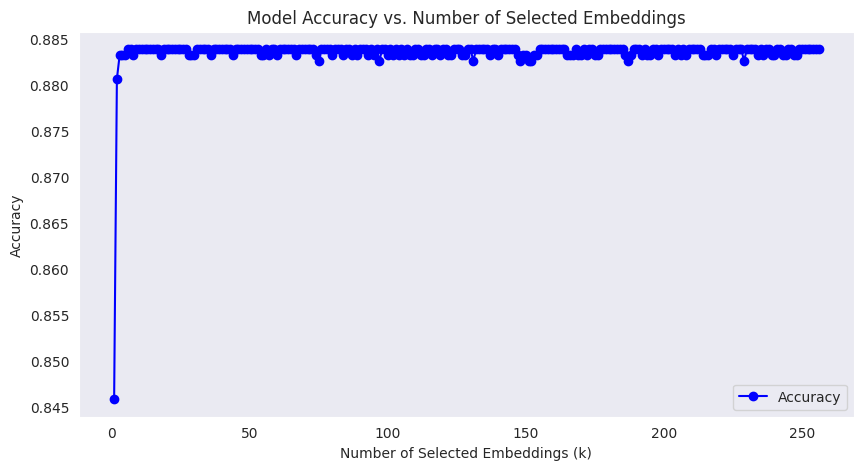

In [117]:
# Plot the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b', label="Accuracy")
plt.xlabel("Number of Selected Embeddings (k)")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Selected Embeddings")
plt.legend()
plt.grid()
plt.show()

In [118]:
f1_scores.index(max(f1_scores))

5

In [122]:
df_sleep.head(4)

,RegistrationCode,night,Date,StudyStatus,Warnings,BraceletMessage,StudyStartTime,StudyEndTime,TotalApneaSleepTime,TotalAH_CentralValidSleepTime,...,PhysicalSleepTime,PhysicalWakeTime,%DeepSleep,%REM,%LightSleep,%Wake,%Sleep,StudyStatus_filled,year_month,gender
0,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
1,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
2,10K_1000942861,2.0,2021-12-25 22:54:26,0x20,NaN,NaN,82466.0,39266.0,25885.0,NaN,...,2021-12-25 23:03:58.185430463,2021-12-26 08:16:11.298013245,17.777013,29.583763,52.639223,39.437500,60.562500,0x20,2021-12-01,M
3,10K_1000942861,2.0,2021-12-25 22:54:26,0x20,NaN,NaN,82466.0,39266.0,25885.0,NaN,...,2021-12-25 23:03:58.185430463,2021-12-26 08:16:11.298013245,17.777013,29.583763,52.639223,39.437500,60.562500,0x20,2021-12-01,M


In [124]:
merged_df = pd.merge(df_sleep, df_conditions_baseline, on='RegistrationCode')

# Count distinct values in 'english_name' column
counts = merged_df['english_name'].value_counts()

# Print the counts
print(counts)

english_name
Hyperlipoproteinaemia                        14366
Haemorrhoids                                 12868
Spinal pain                                  12551
Attention deficit hyperactivity disorder     10048
Essential hypertension                        7213
                                             ...  
Acute or subacute infectious endocarditis        1
Dermatophytosis of foot                          1
Malignant neoplasms of testis                    1
Congenital hearing impairment                    1
Neutropaenia                                     1
Name: count, Length: 392, dtype: int64


In [127]:
# Filtering values that contain either 'sleep' or 'hapnea'
filtered_counts = counts[counts.index.str.contains('sleep', case=False) | counts.index.str.contains('apnoae', case=False)]

# Display the filtered counts
print(filtered_counts)

english_name
Obstructive sleep apnoea    1803
Central sleep apnoeas         18
Name: count, dtype: int64


In [166]:
filter_df = df_cgm[df_cgm['RegistrationCode']=='10K_1000942861']
# Filter by day 14 and month 12
filtered_df_date = filter_df[(filter_df['Date'].dt.day == 14) & (filter_df['Date'].dt.month == 12)]
filtered_df_date

,RegistrationCode,ConnectionID,Date,GlucoseValue,PPGR
0,10K_1000942861,5285357363,2021-12-14 09:26:00,109.8,10.800
1,10K_1000942861,5285357363,2021-12-14 09:41:00,120.6,0.000
2,10K_1000942861,5285357363,2021-12-14 09:56:00,136.8,0.000
3,10K_1000942861,5285357363,2021-12-14 10:11:00,135.0,0.000
4,10K_1000942861,5285357363,2021-12-14 10:26:00,117.0,0.000
5,10K_1000942861,5285357363,2021-12-14 10:41:00,104.4,21.600
6,10K_1000942861,5285357363,2021-12-14 10:56:00,100.8,31.950
7,10K_1000942861,5285357363,2021-12-14 11:11:00,100.8,35.775
8,10K_1000942861,5285357363,2021-12-14 11:26:00,102.6,35.775
9,10K_1000942861,5285357363,2021-12-14 11:41:00,118.8,4.500


In [167]:
general_info.head(3)

,RegistrationCode,Date,standing_three_min_blood_pressure_diastolic,dizziness,trunk_fat,lying_blood_pressure_pulse_rate,body_fat,is_getting_period,fingers_grip_left,lying_blood_pressure_systolic,...,blood_pressure_letter_to_physician,age,sitting_another_hand_blood_pressure_pulse_rate,us_state,country,month_of_birth,StudyTypeID5,StudyTypeID2,StudyTypeID8,sitting_second_blood_pressure_diastolic
0,10K_1000942861,2021-12-13 07:09:38.954985,90.0,False,NaN,50.0,NaN,NaN,NaN,139.0,...,NaN,54.0,NaN,None,IL,8.0,NaN,NaN,NaN,NaN
1,10K_1001201093,2021-08-26 07:39:21.411519,74.0,False,NaN,66.0,NaN,NaN,NaN,100.0,...,NaN,42.0,NaN,None,IL,8.0,NaN,NaN,NaN,NaN
2,10K_1001201093,2023-09-12 10:23:05.534125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Given,44.0,73.0,None,IL,8.0,NaN,NaN,NaN,57.0


In [169]:
# 1. Convert 'Date' to a date (no time component)
df_cgm['Date'] = pd.to_datetime(df_cgm['Date']).dt.date
df_counts = df_cgm.groupby(['RegistrationCode', 'Date']).size().reset_index(name='DataPointsCount')
df_counts.head(5)

,RegistrationCode,Date,DataPointsCount
0,10K_1000942861,2021-12-14,59
1,10K_1000942861,2021-12-15,96
2,10K_1000942861,2021-12-16,96
3,10K_1000942861,2021-12-17,96
4,10K_1000942861,2021-12-18,96


In [171]:
df_counts.shape

(136887, 3)

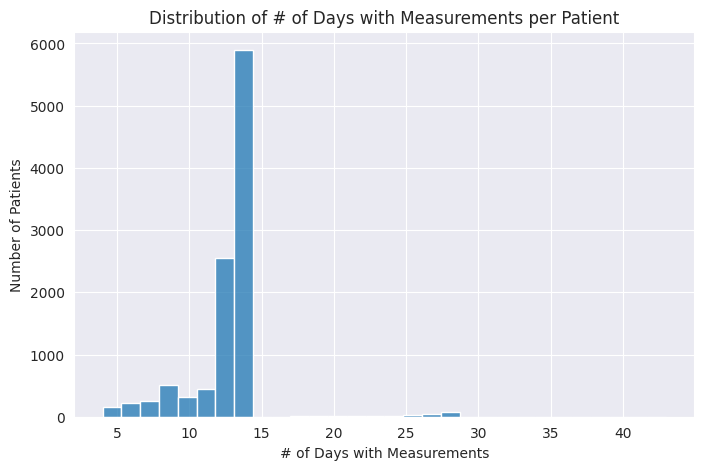

In [172]:
# 1. Count how many days each patient has
df_days_per_patient = df_counts.groupby('RegistrationCode')['Date'].nunique().reset_index(name='DaysWithMeasurement')

# 2. Plot the distribution (Histogram) of days each patient has
plt.figure(figsize=(8, 5))
sns.histplot(df_days_per_patient['DaysWithMeasurement'], bins=30, kde=False)
plt.title('Distribution of # of Days with Measurements per Patient')
plt.xlabel('# of Days with Measurements')
plt.ylabel('Number of Patients')
plt.show()

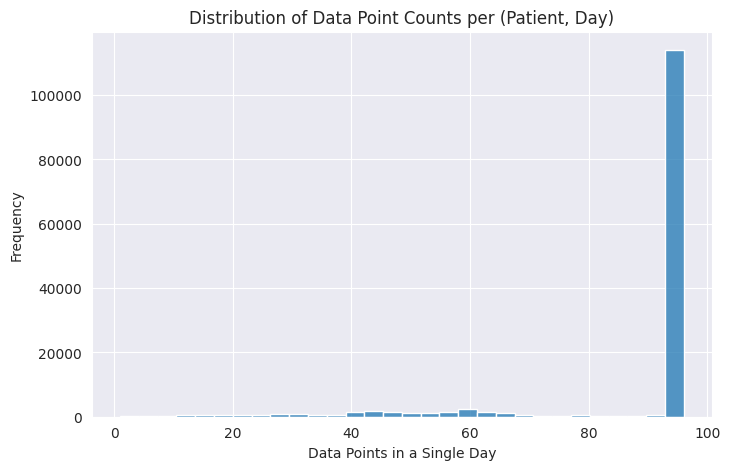

In [173]:
# 1. Plot the distribution (Histogram) of data points per (Patient, Day)
plt.figure(figsize=(8, 5))
sns.histplot(df_counts['DataPointsCount'], bins=30, kde=False)
plt.title('Distribution of Data Point Counts per (Patient, Day)')
plt.xlabel('Data Points in a Single Day')
plt.ylabel('Frequency')
plt.show()

In [176]:
from sklearn.decomposition import NMF
# Group the data by patient (RegistrationCode) and day
grouped = df_cgm.groupby(['RegistrationCode', 'Date'])

# Identify groups (patient/day) with exactly 96 data points
valid_groups = [name for name, group in grouped if len(group) == 96]
# Build a list of signals (each signal is an array of 96 sorted measurements)
signals = []
for group_key in valid_groups:
    group = grouped.get_group(group_key)
    group_sorted = group.sort_values('Date')
    # Collect the measurements (assuming the column of interest is 'GlucoseValue')
    signals.append(group_sorted['GlucoseValue'].values)

# Convert the list to a matrix: each row is a daily signal with 96 measurements.
X = np.array(signals)
print("Data matrix shape:", X.shape)  # Should be (n_samples, 96)



Data matrix shape: (112643, 96)


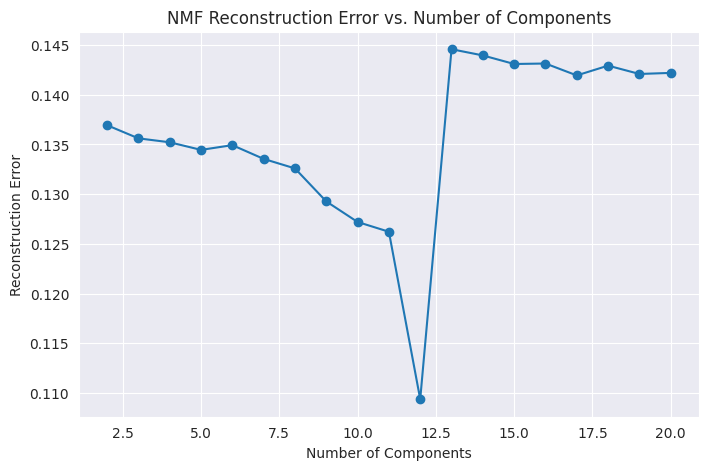

In [189]:
# --- 2. Finding the Optimal Number of NMF Components ---

errors = []
components_range = range(2, 21)  # Testing from 2 to 10 components

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvda', random_state=0, max_iter=500)
    W = model.fit_transform(X)
    H = model.components_
    reconstruction = np.dot(W, H)
    error = np.linalg.norm(X - reconstruction)/ np.linalg.norm(X)  # Frobenius norm
    errors.append(error)

# Plot reconstruction error vs. number of components
plt.figure(figsize=(8, 5))
plt.plot(list(components_range), errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (Relative)')
plt.title('NMF Reconstruction Error vs. Number of Components')
plt.show()

In [187]:
# Choose the optimal number of components (e.g., the one with the lowest error)
optimal_k = components_range[np.argmin(errors)]
print("Optimal number of components:", optimal_k)


Optimal number of components: 12


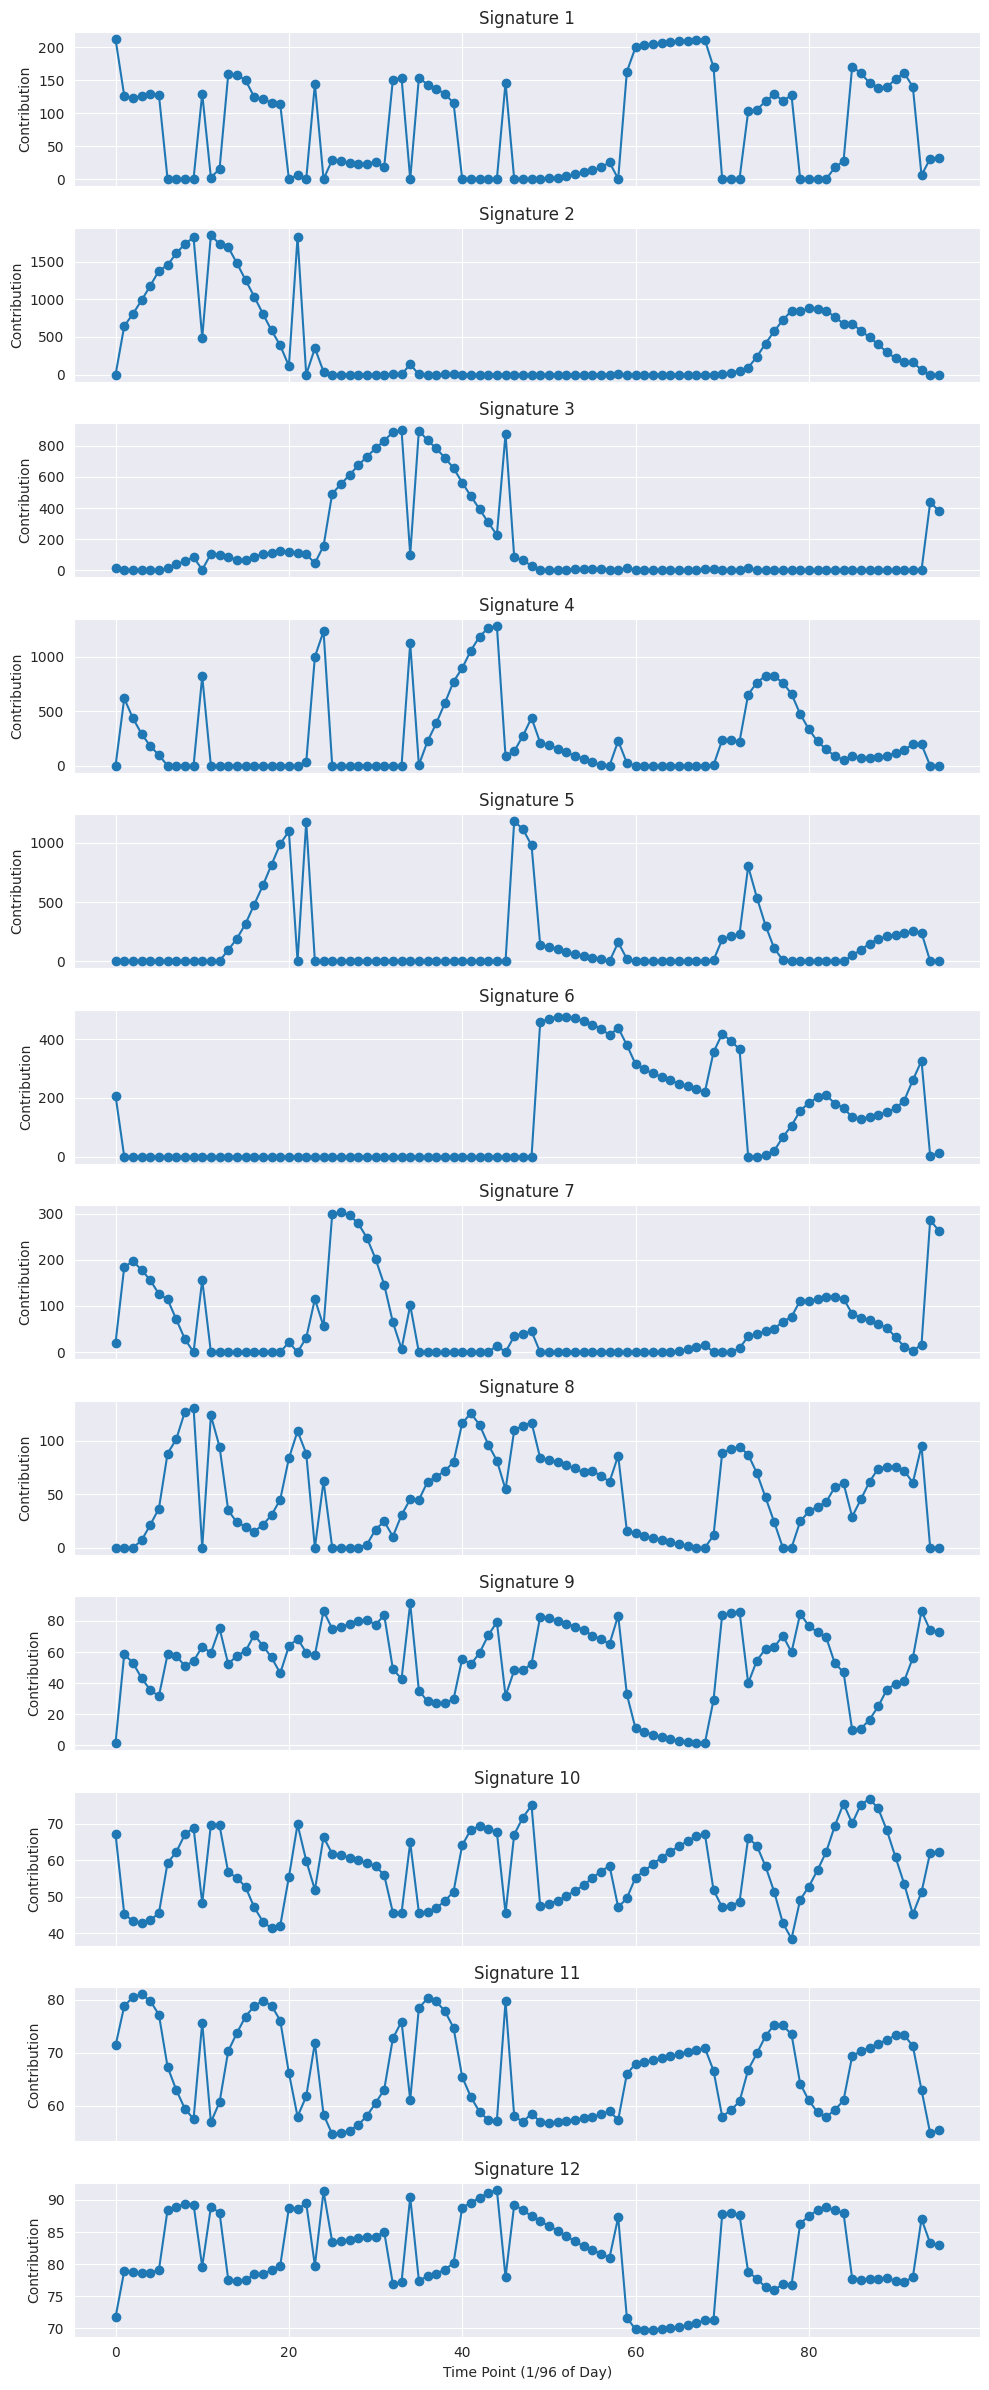

In [188]:

# --- 3. Perform NMF with the Optimal Number of Components ---

model = NMF(n_components=optimal_k, init='nndsvda', random_state=0, max_iter=500)
W = model.fit_transform(X)  # Coefficient matrix: (n_samples x optimal_k)
H = model.components_       # Signature matrix: (optimal_k x 96)

# --- 4. Plot the Signatures ---

# Each row of H is a signature representing a pattern across 96 time points.
fig, axs = plt.subplots(optimal_k, 1, figsize=(10, 2 * optimal_k), sharex=True)

# Create a time axis corresponding to the 96 points (e.g., representing 15-minute intervals over a day)
time = np.arange(96)

for i in range(optimal_k):
    axs[i].plot(time, H[i, :], marker='o')
    axs[i].set_title(f'Signature {i + 1}')
    axs[i].set_ylabel('Contribution')
    axs[i].grid(True)

plt.xlabel('Time Point (1/96 of Day)')
plt.tight_layout()
plt.show()

In [196]:
max(df_counts['Date'])

datetime.date(2025, 2, 27)

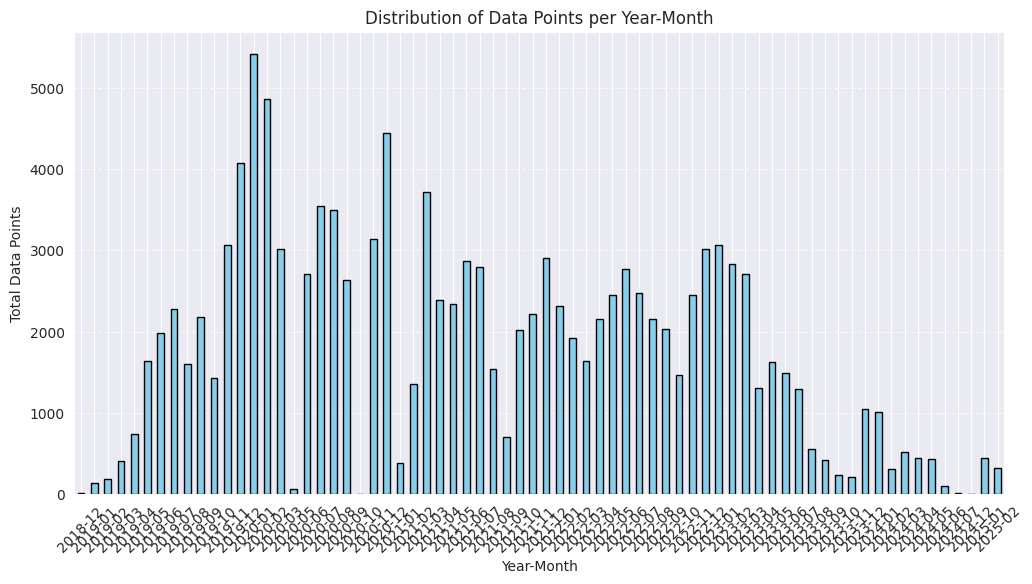

In [200]:
df_counts["Date"] = pd.to_datetime(df_counts["Date"])

df_counts["Year-Month"] = df_counts["Date"].dt.to_period("M")

# Aggregate counts per month
monthly_counts = df_counts.groupby("Year-Month")["DataPointsCount"].sum() / 96

# Plot
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Year-Month")
plt.ylabel("Total Data Points")
plt.title("Distribution of Data Points per Year-Month")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [202]:
df_counts.head(25)

,RegistrationCode,Date,DataPointsCount,Year-Month
0,10K_1000942861,2021-12-14,59,2021-12
1,10K_1000942861,2021-12-15,96,2021-12
2,10K_1000942861,2021-12-16,96,2021-12
3,10K_1000942861,2021-12-17,96,2021-12
4,10K_1000942861,2021-12-18,96,2021-12
5,10K_1000942861,2021-12-19,96,2021-12
6,10K_1000942861,2021-12-20,96,2021-12
7,10K_1000942861,2021-12-21,96,2021-12
8,10K_1000942861,2021-12-22,96,2021-12
9,10K_1000942861,2021-12-23,96,2021-12
